# PyTorch Workflow

Let's explore an example PyTorch end-to-end workflow.

In [ ]:
what_were_covering = {1: "data (prepare and load)",
                                      2: "build model",
                                      3: "fitting the model to data (training)",
                                      4: "making predictions and evaluating a model (inference)",
                                      5: "saving and loading a model",
                                      6: "putting it all together"}

what_were_covering

{1: 'data (prepare and load)',
 2: 'build model',
 3: 'fitting the model to data (training)',
 4: 'making predictions and evaluating a model (inference)',
 5: 'saving and loading a model',
 6: 'putting it all together'}

In [ ]:
import torch
from torch import nn # nn contains all of PyTorch's building blocks for neural networks
import matplotlib.pyplot as plt

# Check PyTorch version
torch.__version__

'2.1.0+cu121'

## 1. Data (preparing and loading)

Data can be almost anything... in machine learning.

* Excel spreadsheet
* Images of any kind
* Videos (Youtube has lots of data...)
* Audio like songs or podcasts
* DNA
* Text

Machine learning is a game of two parts:
1. Get data into a numerical representation.
2. Build a model to learn patterns in that numerical representation.

To showcase this, let's create some *known* data using the linear regression formula.

We'll use a linear regression formula to make a straight line with *known* **parameters.**

In [ ]:
# Create *known* parameters
weight = 0.7
bias = 0.3

# Create
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [ ]:
len(X), len(y)

(50, 50)

### Splitting data into training and test sets
(one of the most important concepts in machine learning in general)

Let's create a training and test set with our data.

In [ ]:
''' Three datasets
1) training set : Model learns patterns from here
2) validation set : Tune model patterns
3) test set : See if the model is ready for the wild

=> Generalization : The ability for a machine learning model to perform well on data it hasn't seen before.
'''

In [ ]:
# Create a train/test split
train_split = int(0.8 * len(X))

X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

How might we better visualize our data?

This is where the data explorer's motto comes in!

"Visualize, visualize, visualize!"

In [ ]:
def plot_predictions(train_data=X_train,
                                train_labels=y_train,
                                test_data=X_test,
                                test_labels=y_test,
                                predictions=None):

    """
    Plots training data, test data and compares predictions.
    """
    plt.figure(figsize=(6,4))

    # Plot training data in blue
    plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

    # Plot test data n green
    plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

    # Are there predictions?
    if predictions is not None:
        # Plot the predictions if they exist
        plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

    # Show the legend()
    plt.legend(prop={"size":14});

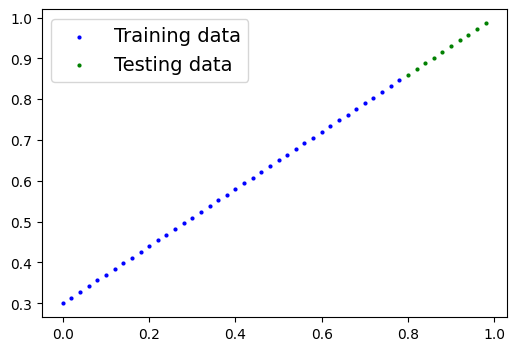

In [ ]:
plot_predictions();

## 2. Build model

Our first PyTorch model!

This is very exciting... let's do it!

Because we're going to be building classes throughout the course, I'd recommend getting familiar with OOP in Python, to do so you can use the following resource from Real Python: https://realpython.com/python3-object-oriented-programming/

What our model does:
* Start with random values (weight & bias)
* Look at training data and adjust the random values to better represent (or get close to) the ideal values (the weight & bias values we used to create the data)

How does it do so?

Through two main algorithms:
1. Gradient descent - https://youtu.be/IHZwWFHWa-w
2. Backpropagation - https://youtu.be/Ilg3gGewQ5U

In [ ]:
# Create linear regression model class

class LinearRegressionModel(nn.Module): # <= almost everything in PyTorch inherits from nn.Module
    def __init__(self):
        super().__init__()

        # initialize model parameters
        self.weights = nn.Parameter(torch.randn(1, # <- start with a random weight and try to adjust it to the ideal weight
                                                                          requires_grad=True, # <- can this parameter be updated via gradient descent?
                                                                          dtype=torch.float)) # <- PyTorch loves the datatype torch.float32

        self.bias = nn.Parameter(torch.randn(1, # <- start with a random bias and try to adjust it to the ideal bias
                                                                    requires_grad=True, # <- can this parameter be updated via gradient descent?
                                                                    dtype=torch.float)) # <- PyTorch loves the datatype torch.float32

    # Forward method to define the computation in the model
    def forward(self, x:torch.Tensor) -> torch.Tensor: # <- "x" is the input data
        return self.weights * x + self.bias # this is the linear regression formula

### PyTorch model building essentials

* torch.nn - contains all of the buildings for computational graphs (a neural network can be considered a computational graph)
* torch.nn.Parameter - what parameters should our model try and learn, often a PyTorch layer from torch.nn will set these for us
* torch.nn.Module - The base class for all neural network modules, if you subclass it, you should overwrite forward()
* torch.optim - this where the optimizers in PyTorch live, they will help with gradient descent
* def forward() - All nn.Module subclasses require you to overwrite forward(), this method defines what happens in the forward computation

See more of these essential modules via the PyTorch cheatseet - https://pytorch.org/tutorials/beginner/ptcheat.html

### Checking the contents of our PyTorch model

Now we've created a model, let's see what's inside...

So we can check our model parameters or what's inside our model using `.parameters()`.

In [ ]:
# Create a random seed
torch.manual_seed(42)

# Create an instance of the model (this is a subclass of nn.Module)
model_0 = LinearRegressionModel()

# Check out the parameters
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [ ]:
# List named parameters
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

### Making prediction using `torch.inference_mode()`

To check our model's predictive power, let's see how well it predicts `y_test` based on `X_test`.

When we pass data through our model, it's going to run it through the forward() method.


In [ ]:
X_test, y_test

(tensor([[0.8000],
         [0.8200],
         [0.8400],
         [0.8600],
         [0.8800],
         [0.9000],
         [0.9200],
         [0.9400],
         [0.9600],
         [0.9800]]),
 tensor([[0.8600],
         [0.8740],
         [0.8880],
         [0.9020],
         [0.9160],
         [0.9300],
         [0.9440],
         [0.9580],
         [0.9720],
         [0.9860]]))

In [ ]:
# Make predictions with model
with torch.inference_mode():
    y_preds= model_0(X_test)

# You can also do something similar with torch.no_grad(), however, inference_mode() is preferred
# with torch.no_grad():
#    y_preds = model_0(X_test)

y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

See more on inference mode here - https://twitter.com/PyTorch/status/1437838231505096708

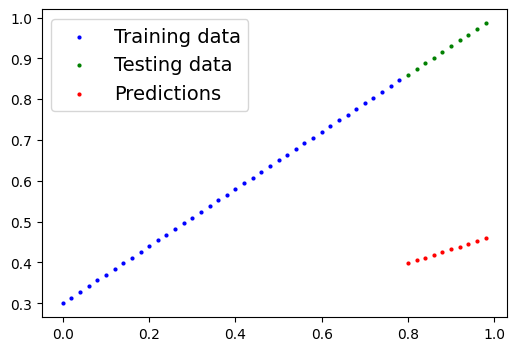

In [ ]:
plot_predictions(predictions=y_preds)

## 3. Train model

The whole idea of training is for a model to move from some *unknown* parameters (these may be random) to some *known* parameters.

Or in other words from a poor representation of the data to a better representation of the data.

One way to measure how poor or how wrong your models predictions are is to use a loss function.

* Note: Loss function may also be called cost function or criterion in different areas. For our case, we're going to refer to it as a loss function.

Things we need to train:

* **Loss function:** A function to measure how wrong your model's predictions are to the ideal outputs, lower is better.
* **Optimizer:** Takes into account the loss of a model and adjusts the model's parameters (e.g. weight & bias in our case) to improve the loss function.

And specifically for PyTorch, we need:

* A training loop
* A testing loop

In [ ]:
# Setup a loss funciton
loss_func = nn.L1Loss()

# Setup an optimizer (stochastic gradient descent)
optimizer = torch.optim.SGD(params=model_0.parameters(), # we want to optimize the parameters present in our model
                            lr=0.01) # lr = learning rate = possibly the most important hyperparameter you can set

### Building a training loop (and a testing loop) in PyTorch

A couple of things we need in a training loop:
0. Loop through the data and do...
1. Forward pass (this involves data moving through our model's `forward()` functions) to make predictions on data - also called forward propagation
2. Calculate the loss (compare forward pass predictions to ground truth labels)
3. Optimizer zero grad
4. Loss backward - move backwards through the network to calculate the gradients of each of the parameters of our model with respect to the loss (**backpropagation**)
5. Optimizer step - use the optimizer to adjust our model's parameters to try and improve the loss (**gradient descent**)

In [ ]:
torch.manual_seed(42)

# An epoch is one loop through the data...(this is a hyperparameter because we've set it ourselves)
epochs = 200

# Track different values
epoch_count = []
loss_values = []
test_loss_values = []

### Training
# 0. Loop through the data
for epoch in range(epochs):

    # Set the model to training mode
    model_0.train() # train mode in PyTorch sets all parameters that require gradients to require gradients.

    # 1. Forward pass
    y_pred = model_0(X_train)

    # 2. Calculate the loss
    loss = loss_func(y_pred, y_train)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Perform backpropagation on the loss with respect to the parameters of the model
    loss.backward()

    # 5. Step the optimizer (perform gradient descent)
    optimizer.step() # by default how the optimizer changes will accumulate through the loop so... we have to zero them above in step 3 for the next iteration of the loop

    ### Testing
    model_0.eval() # turns off different settings in the model not needed for evaluation/testing (dropout/batch norm layers)
    with torch.inference_mode(): # turns off gradient tracking & a couple more things behind the scenes

        # 1. Do the forward pass
        test_pred = model_0(X_test)

        # 2. Calculate the loss
        test_loss = loss_func(test_pred, y_test)

    # Print out what's happenin'
    if epoch % 10 == 0:
        epoch_count.append(epoch)
        loss_values.append(loss.item())
        test_loss_values.append(test_loss.item())
        print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}")

        # Print out model state_dict()
        print(model_0.state_dict())

Epoch: 0 | Loss: 0.31288138031959534 | Test loss: 0.48106518387794495
OrderedDict([('weights', tensor([0.3406])), ('bias', tensor([0.1388]))])
Epoch: 10 | Loss: 0.1976713240146637 | Test loss: 0.3463551998138428
OrderedDict([('weights', tensor([0.3796])), ('bias', tensor([0.2388]))])
Epoch: 20 | Loss: 0.08908725529909134 | Test loss: 0.21729660034179688
OrderedDict([('weights', tensor([0.4184])), ('bias', tensor([0.3333]))])
Epoch: 30 | Loss: 0.053148526698350906 | Test loss: 0.14464017748832703
OrderedDict([('weights', tensor([0.4512])), ('bias', tensor([0.3768]))])
Epoch: 40 | Loss: 0.04543796554207802 | Test loss: 0.11360953003168106
OrderedDict([('weights', tensor([0.4748])), ('bias', tensor([0.3868]))])
Epoch: 50 | Loss: 0.04167863354086876 | Test loss: 0.09919948130846024
OrderedDict([('weights', tensor([0.4938])), ('bias', tensor([0.3843]))])
Epoch: 60 | Loss: 0.03818932920694351 | Test loss: 0.08886633068323135
OrderedDict([('weights', tensor([0.5116])), ('bias', tensor([0.3788

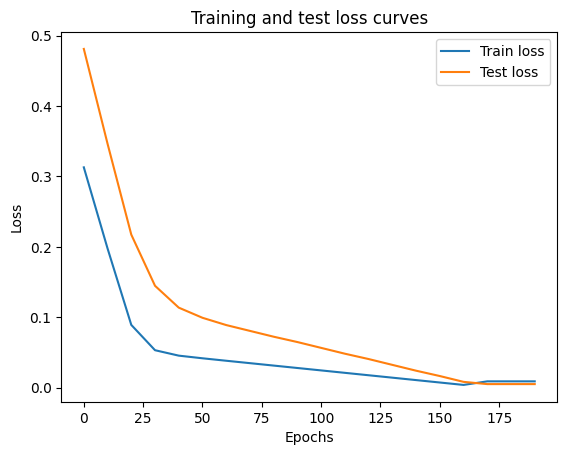

In [ ]:
# Plot the loss curves
plt.plot(epoch_count, loss_values, label='Train loss')
plt.plot(epoch_count, test_loss_values, label='Test loss')
plt.title('Training and test loss curves')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()

plt.show()

In [ ]:
with torch.inference_mode():
    y_preds = model_0(X_test)

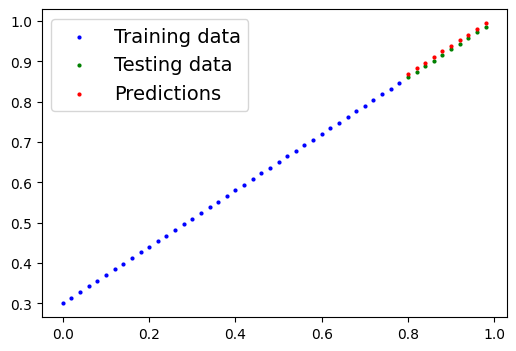

In [ ]:
plot_predictions(predictions=y_preds)

## Saving a model in PyTorch

There are three main methods you should know about for saving and loading models in PyTorch.

1. `torch.save()` - allows you save a PyTorch object in Python's pickle format
2. `torch.load()` - allows you load a saved PyTorch object
3. `torch.nn.Module.load_state_dict()` - this allows you to load a model's saved state dictionary

In [ ]:
# Saving our PyTorch model
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = '01_pytorch_workflow_model_0.pth'
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")

torch.save(obj=model_0.state_dict(),
                  f=MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_workflow_model_0.pth


In [ ]:
!ls -l models

total 4
-rw-r--r-- 1 root root 1680 Jan 24 13:21 01_pytorch_workflow_model_0.pth


## Loading a PyTorch model

Since we saved our model's `state_dict()` rather the entire model, we'll create a new instance of our model class and load the saved `state_dict()` into that.

In [ ]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [ ]:
# To load in a saved state_dict we have to instantiate a new instance of our model class
loaded_model_0 = LinearRegressionModel()

# Load the saved state_dict of model_0 (this wll update the new instance with updated parameters)
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [ ]:
loaded_model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [ ]:
# Make some predictions with our loaded model
loaded_model_0.eval()
with torch.inference_mode():
    loaded_model_preds = loaded_model_0(X_test)

loaded_model_preds

tensor([[0.8685],
        [0.8825],
        [0.8965],
        [0.9105],
        [0.9245],
        [0.9384],
        [0.9524],
        [0.9664],
        [0.9804],
        [0.9944]])

In [ ]:
# Compare loaded model preds with original model preds
y_preds == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

## 6. Putting it all together

Let's go back through the steps above and see it all in one place.

In [ ]:
# Import PyTorch and matplotlib
import torch
from torch import nn
import matplotlib.pyplot as plt

# Check PyTorch version
torch.__version__

'2.1.0+cu121'

Create device-agnostic code.

This means if we've got access to a GPU, our code will use it (for potentially faster computing).

If no GPU is available, the code will default to using CPU.

In [ ]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cpu


### 6.1 Data

In [ ]:
# Create some data using the linear regression formula of y = weight * X + bias

weight = 0.7
bias = 0.3

# Create range values
start = 0
end = 1
step = 0.02

# Create X and y (features and labels)
X = torch.arange(start, end, step).unsqueeze(dim=1) # without unsqueeze, erorrs will pop up
y = weight * X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [ ]:
# split data
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [ ]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
    '''
    Plots training data, test data and compares predictions
    '''
    plt.figure(figsize=(6,4))

    plt.scatter(train_data, train_labels, c='b', s=4, label='Training data')
    plt.scatter(test_data, test_labels, c='g', s=4, label='Testing data')

    if predictions is not None:
        plt.scatter(test_data, predictions, c='r', s=4, label='Predictions')

    plt.legend(prop={'size':9});

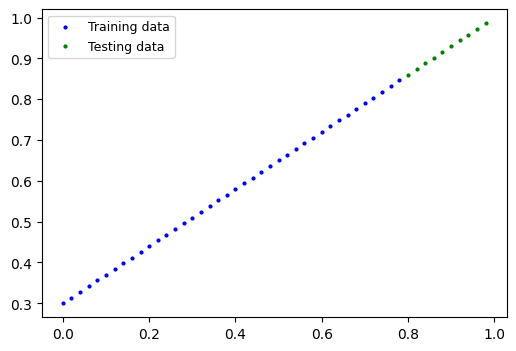

In [ ]:
# Plot the data
plot_predictions();

### 6.2 Building a PyTorch Linear model

In [ ]:
# Create a linear model by subclassing nn.Module
class LinearRegressionModelV2(nn.Module):
    def __init__(self):
        super().__init__()

        # Use nn.Linear() for creating the model parameters also called: linear transform, probing layer, fully connected layer, dense layer
        self.linear_layer = nn.Linear(in_features=1, out_features=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear_layer(x)

# Set the manual seed
torch.manual_seed(42)
model_1 = LinearRegressionModelV2()
model_1, model_1.state_dict()

(LinearRegressionModelV2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

In [ ]:
# Check the model current device
next(model_1.parameters()).device

device(type='cpu')

In [ ]:
# Set the model to use the target device
model_1.to(device)
next(model_1.parameters()).device

device(type='cpu')

### 6.3 Training

For training, we need:
* Loss function
* Optimizer
* Training loop
* Testing loop

In [ ]:
# Setup loss function
loss_func = nn.L1Loss() # same as MAE

# Setup optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=.01)

In [ ]:
# Let's write a training loop
torch.manual_seed(42)

epochs = 200

# Put data on the target device (device agnostic code for data)
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

for epoch in range(epochs):

    model_1.train()

    # 1. Forward pass
    y_pred = model_1(X_train)

    # 2. Calculate the loss
    loss = loss_func(y_pred, y_train)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Perform backpropagation
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_1.eval()

    with torch.inference_mode():
        test_pred = model_1(X_test)
        test_loss = loss_func(test_pred, y_test)

    # Print out what's happening

    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}")

Epoch: 0 | Loss: 0.5551779866218567 | Test loss: 0.5739762187004089
Epoch: 10 | Loss: 0.4399680495262146 | Test loss: 0.4392663538455963
Epoch: 20 | Loss: 0.3247582018375397 | Test loss: 0.30455657839775085
Epoch: 30 | Loss: 0.20954827964305878 | Test loss: 0.16984674334526062
Epoch: 40 | Loss: 0.09433844685554504 | Test loss: 0.03513689711689949
Epoch: 50 | Loss: 0.023886386305093765 | Test loss: 0.04784906655550003
Epoch: 60 | Loss: 0.0199567973613739 | Test loss: 0.04580312222242355
Epoch: 70 | Loss: 0.016517987474799156 | Test loss: 0.0375305712223053
Epoch: 80 | Loss: 0.013089170679450035 | Test loss: 0.029944902285933495
Epoch: 90 | Loss: 0.009653178043663502 | Test loss: 0.02167237363755703
Epoch: 100 | Loss: 0.006215679459273815 | Test loss: 0.014086711220443249
Epoch: 110 | Loss: 0.002787243574857712 | Test loss: 0.005814164876937866
Epoch: 120 | Loss: 0.0012645035749301314 | Test loss: 0.013801807537674904
Epoch: 130 | Loss: 0.0012645035749301314 | Test loss: 0.01380180753767

In [ ]:
model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6968]])),
             ('linear_layer.bias', tensor([0.3025]))])

In [ ]:
weight, bias

(0.7, 0.3)

### 6.4 Making and evaluating predictions

In [ ]:
# Turn model into evaluation mode
model_1.eval()

# Make predictions on the test data
with torch.inference_mode():
    y_preds = model_1(X_test)

y_preds

tensor([[0.8600],
        [0.8739],
        [0.8878],
        [0.9018],
        [0.9157],
        [0.9296],
        [0.9436],
        [0.9575],
        [0.9714],
        [0.9854]])

In [ ]:
# if device="cuda:0", then...

# y_preds.item()
# y_preds.cpu()

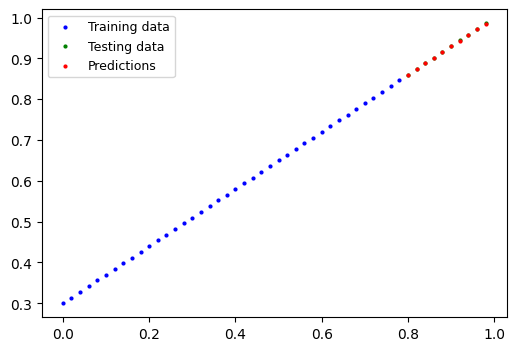

In [ ]:
# Check out our model predictions visually
plot_predictions(predictions=y_preds);

### 6.5 Saving & loading a trained model

In [ ]:
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "01_pytorch_workflow_model_1.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_1.state_dict(),
                  f=MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_workflow_model_1.pth


In [ ]:
# Load a PyTorch

# Create a new instance of linear regression model V2
loaded_model_1 = LinearRegressionModelV2()

# Load the saved model_1 state_dict
loaded_model_1.load_state_dict(torch.load(MODEL_SAVE_PATH))

# Put the loaded model to device
loaded_model_1.to(device)

LinearRegressionModelV2(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)

In [ ]:
next(loaded_model_1.parameters()).device

device(type='cpu')

In [ ]:
loaded_model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6968]])),
             ('linear_layer.bias', tensor([0.3025]))])

In [ ]:
# Evaluate loaded model
loaded_model_1.eval()
with torch.inference_mode():
    loaded_model_1_preds = loaded_model_1(X_test)

y_preds == loaded_model_1_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

## Exercises & Extra-curriculum

In [1]:
import datetime

print(f"Last updated: {datetime.datetime.now()}")

Last updated: 2024-01-29 02:48:10.514278


In [2]:
import torch
import matplotlib.pyplot as plt
import torch.nn as nn

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [5]:
# 1. Create a straight line dataset using the linear regression formula (weight * X + bias).

weight = 0.3
bias = 0.9

X = torch.arange(0,1,0.01).unsqueeze(dim=1)
y = weight * X + bias

print(f"Number of X samples: {len(X)}")
print(f"Number of y samples: {len(y)}")
print(X[:10])
print(y[:10])

Number of X samples: 100
Number of y samples: 100
tensor([[0.0000],
        [0.0100],
        [0.0200],
        [0.0300],
        [0.0400],
        [0.0500],
        [0.0600],
        [0.0700],
        [0.0800],
        [0.0900]])
tensor([[0.9000],
        [0.9030],
        [0.9060],
        [0.9090],
        [0.9120],
        [0.9150],
        [0.9180],
        [0.9210],
        [0.9240],
        [0.9270]])


In [6]:
# Split the data into train and test
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(80, 80, 20, 20)

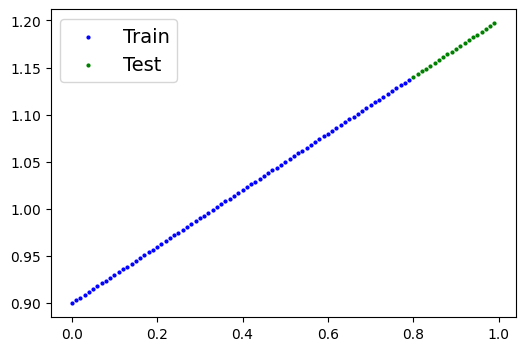

In [7]:
# Plot data
def plot_predictions(train_data=X_train, train_labels=y_train, test_data=X_test, test_labels=y_test, predictions=None):
    plt.figure(figsize=(6,4))
    plt.scatter(train_data, train_labels, c='b', s=4, label='Train')
    plt.scatter(test_data, test_labels, c='g', s=4, label='Test')
    if predictions is not None:
        plt.scatter(test_data, predictions, c='r', s=4, label='Prediction')
    plt.legend(prop={'size':14});

plot_predictions()

In [8]:
# 2. Build a PyTorch model by subclassing nn.Module.

class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.weight = nn.Parameter(data=torch.randn(1, requires_grad=True, dtype=torch.float))

        self.bias = nn.Parameter(data=torch.randn(1, requires_grad=True, dtype=torch.float))

    def forward(self, x):
        return self.weight*x + self.bias

In [12]:
torch.manual_seed(42)

model_1 = LinearRegressionModel()
model_1.state_dict()

OrderedDict([('weight', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [13]:
model_1.to(device)
list(model_1.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [14]:
# 3. Create a loss function and optimizer using nn.L1Loss() and torch.optim.SGD(params, lr) respectively.

loss_func = nn.L1Loss()
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=.01)

# Training loop
torch.manual_seed(42)

epochs = 300

X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

for epoch in range(epochs):

    model_1.train()

    y_preds = model_1(X_train)
    loss = loss_func(y_preds, y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 20 == 0:
        model_1.eval()
        with torch.inference_mode():
            test_preds = model_1(X_test)
            test_loss = loss_func(test_preds, y_test)

            print(f"Epoch: {epoch} | Train loss: {loss:.4f} | Test loss: {test_loss:.4f}")

Epoch: 0 | Train loss: 0.7567 | Test loss: 0.7248
Epoch: 20 | Train loss: 0.5255 | Test loss: 0.4541
Epoch: 40 | Train loss: 0.2943 | Test loss: 0.1834
Epoch: 60 | Train loss: 0.0766 | Test loss: 0.0727
Epoch: 80 | Train loss: 0.0526 | Test loss: 0.1158
Epoch: 100 | Train loss: 0.0455 | Test loss: 0.1047
Epoch: 120 | Train loss: 0.0387 | Test loss: 0.0894
Epoch: 140 | Train loss: 0.0318 | Test loss: 0.0741
Epoch: 160 | Train loss: 0.0250 | Test loss: 0.0581
Epoch: 180 | Train loss: 0.0181 | Test loss: 0.0421
Epoch: 200 | Train loss: 0.0113 | Test loss: 0.0258
Epoch: 220 | Train loss: 0.0044 | Test loss: 0.0095
Epoch: 240 | Train loss: 0.0037 | Test loss: 0.0065
Epoch: 260 | Train loss: 0.0037 | Test loss: 0.0065
Epoch: 280 | Train loss: 0.0037 | Test loss: 0.0065


In [16]:
# 4. Make predictions with the trained model on the test data.
model_1.eval()

with torch.inference_mode():
    y_preds = model_1(X_test)

y_preds.cpu()

tensor([[1.1464],
        [1.1495],
        [1.1525],
        [1.1556],
        [1.1587],
        [1.1617],
        [1.1648],
        [1.1679],
        [1.1709],
        [1.1740],
        [1.1771],
        [1.1801],
        [1.1832],
        [1.1863],
        [1.1893],
        [1.1924],
        [1.1955],
        [1.1985],
        [1.2016],
        [1.2047]])

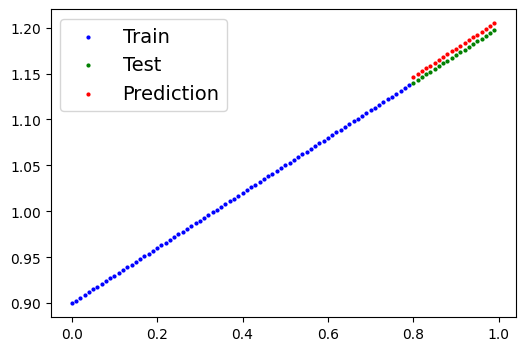

In [17]:
plot_predictions(predictions=y_preds)

In [18]:
# 5. Save trained model's state_dict() to file.

from pathlib import Path

MODEL_PATH = Path('models')
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = '01_pytorch_model'
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

print(f'Saving model to {MODEL_SAVE_PATH}')
torch.save(obj=model_1.state_dict(), f=MODEL_SAVE_PATH)

Saving model to models/01_pytorch_model


In [19]:
loaded_model = LinearRegressionModel()
loaded_model.load_state_dict(torch.load(f=MODEL_SAVE_PATH))
loaded_model.to(device)

LinearRegressionModel()

In [20]:
y_preds_new = loaded_model(X_test)

y_preds == y_preds_new

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

In [21]:
loaded_model.state_dict()

OrderedDict([('weight', tensor([0.3067])), ('bias', tensor([0.9011]))])